# 1. MLP를 이용한 MNIST Dataset 학습 및 테스트 실습

MNIST 데이터는 0부터 9까지의 숫자를 손글씨로 적은 이미지와 그에 대한 레이블 쌍으로 이루어진 총 7만개의 데이터셋입니다.  

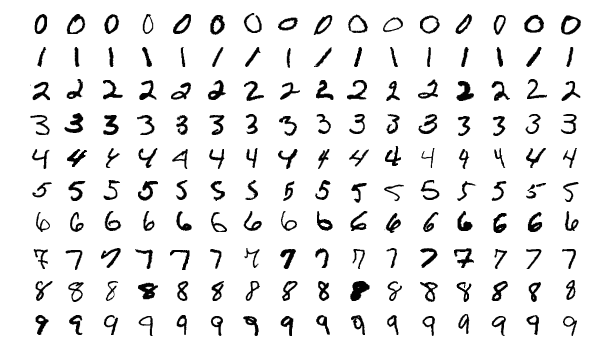

이번 실습에서는 간단한 Multi-Layer Perceptron을 이용하여 MNIST 데이터셋을 학습시키고 훈련된 모델을 이용하여 0~9까지의 숫자를 Classification하는 실습을 진행해보겠습니다.

In [1]:
## 필요한 라이브러리 임포트
import torch
import numpy as np



**MNIST 데이터를 로드하고 시각화해보기 위해 필요한 라이브러리들을 임포트합니다.**  
다운로드하는데 시간이 조금 걸릴 수 있습니다.  
한 번에 더 많은 데이터를 로드하려는 경우 batch_size를 조절할 수 있습니다.

In [2]:
from torchvision import datasets as dsets
import torchvision.transforms as transforms

# 데이터로드에 사용할 서브 프로세스 수
num_workers = 0
# 배치당 로드할 샘플 수
batch_size = 20

# 데이터를 Float Tensor형으로 변환합니다.
transform = transforms.ToTensor()

# 학습 및 테스트 데이터 로드
train_data = dsets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = dsets.MNIST(root='data', train=False, download=True, transform=transform)

# 학습 및 테스트 데이터 로더 준비
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

**다운로드한 MNIST 데이터셋을 한번 시각화 시켜봅시다.**

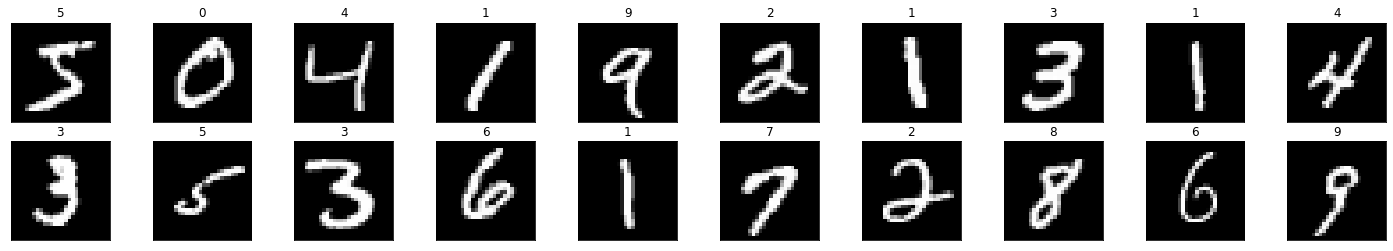

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

**MNIST 데이터를 좀더 세분화하여 시각화 해봅니다.**  
이미지 한장을 불러와 각 픽셀마다의 값을 백분율로 출력합니다.
각 픽셀당 RGB값이 255에 가까워질수록 1에 가까운 값을 가집니다.

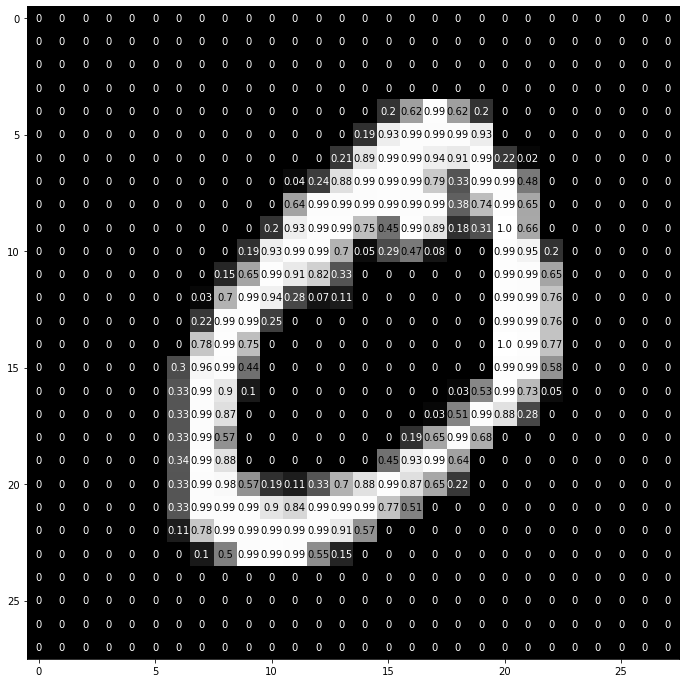

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

**간단한 Multi-layer Perceptron 설계하기**

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## 신경망 구조 정의하기
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) #첫번째 Layer
        self.fc2 = nn.Linear(512, 512) #두번째 Layer
        self.fc3 = nn.Linear(512, 10) #세번째 Layer
        self.dropout = nn.Dropout(0.2) #드롭아웃 Layer
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


**Loss 함수 및 Optimizer 지정하기**
Loss 함수는 CrossEntropyLoss를 사용하고, Optimizer는 SGD를 사용합니다.

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**MLP 학습하기**  
위에서 설계한 MLP를 학습시켜 봅시다.
그래프를 통하여 Loss의 변화를 파악 하여 학습이 올바르게 이루어지고 있는지 확인할 수 있습니다.

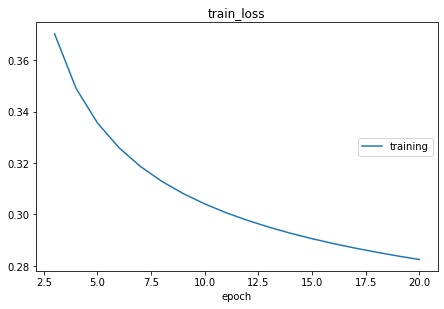

train_loss:
training   (min:    0.282, max:    0.813, cur:    0.282)
Epoch: 20 	Training Loss: 0.282460


In [7]:
from livelossplot import PlotLosses

n_epochs = 20 # 학습 epoch 지정
liveloss = PlotLosses()
model.train() 

for epoch in range(n_epochs):
    logs = {}
    train_loss = 0.0
    ###################
    #    모델 학습    #
    ###################
    for data, target in train_loader:
        # 모든 optimizer 변수와 gradients를 초기화
        optimizer.zero_grad()
        # 정방향 학습 : 입력을 모델로 전달하여 예측된 출력 계산
        output = model(data)
        # Loss 계산
        loss = criterion(output, target)
        # 역전파 : 모델의 매개변수를 고려하여 loss의 gradients를 계산
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 훈련 Loss 업데이트
        train_loss += loss.item()*data.size(0)
        
        visualize_loss = train_loss/len(train_loader.dataset)
        logs['train_loss'] = visualize_loss
    liveloss.update(logs)
    liveloss.draw()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        visualize_loss
        ))

**훈련된 모델 테스트 해보기**

In [8]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.279389

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1108/1135)
Test Accuracy of     2: 88% (914/1032)
Test Accuracy of     3: 90% (916/1010)
Test Accuracy of     4: 92% (910/982)
Test Accuracy of     5: 87% (779/892)
Test Accuracy of     6: 94% (910/958)
Test Accuracy of     7: 91% (942/1028)
Test Accuracy of     8: 88% (863/974)
Test Accuracy of     9: 90% (913/1009)

Test Accuracy (Overall): 92% (9217/10000)


**테스트 결과를 시각화 하기**
각 숫자당 모델이 예측한 값과 실제 값을 시각화합니다.

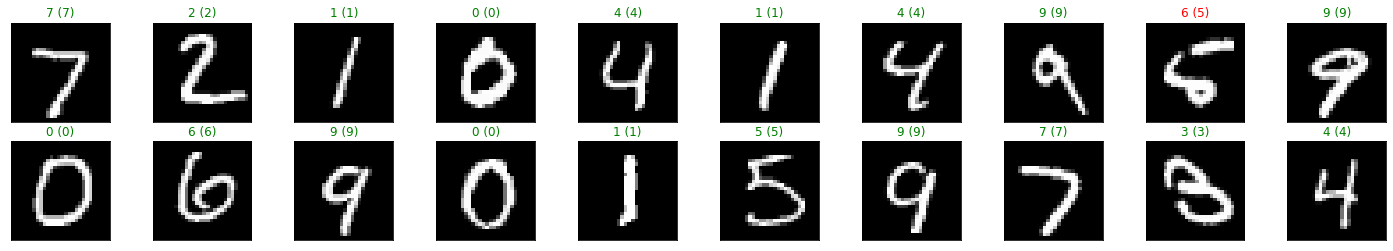

In [9]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))